In [8]:
%matplotlib inline
import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import numpy as np

import time

In [12]:
def test_accuracy(net, dataloader):
  ########TESTING PHASE###########
  
    #check accuracy on whole test set
    correct = 0
    total = 0
    net.eval() #important for deactivating dropout and correctly use batchnorm accumulated statistics
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print('Accuracy of the network on the test set: %d %%' % (
    accuracy))
    return accuracy

In [9]:
n_classes = 10 
n_epochs=20
#transform are heavily used to do simple and complex transformation and data augmentation
transform_train = transforms.Compose(
    [
        #transforms.RandomHorizontalFlip(),
     transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose(
    [
     transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=4,drop_last=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=4,drop_last=True)



Files already downloaded and verified
Files already downloaded and verified


In [10]:
def fit_network(net,n_epochs,trainloader,testloader, learning_rate=0.0001):
    n_loss_print = len(trainloader)
    
    
    net = net.cuda()

    criterion = nn.CrossEntropyLoss().cuda() #it already does softmax computation for use!
    optimizer = optim.Adam(net.parameters(), lr=learning_rate) #better convergency w.r.t simple SGD :)
    
    accuracies=[]
    losses=[]
    t0=time.time()
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        time_epoch=time.time()
        net.train() #important for activating dropout and correctly train batchnorm
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs and cast them into cuda wrapper
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % n_loss_print == (n_loss_print -1):    
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / n_loss_print))
                losses.append(running_loss / n_loss_print)
                running_loss = 0.0
                         
        accuracies.append(test_accuracy(net,testloader))
        print("Epoch done in ",round(time.time()-time_epoch,3)," seconds.\n")
    print("Finished Training, total time=",round(time.time()-t0,3))
            
    
    plt.title("Accuracy vs epoch")
    plt.plot(range(1,n_epochs+1),accuracies)
    for a,b in zip (range(1,n_epochs+1),accuracies):
        plt.text(a,b,str(round(b,2)))
    plt.show()
    plt.title("loss vs epoch")
    
    plt.plot(range(1,n_epochs+1),losses)
    for a,b in zip (range(1,n_epochs+1),losses):
        plt.text(a,b,str(round(b,2)))
    plt.show()
        
    

[1,   195] loss: 1.109
Accuracy of the network on the test set: 73 %
Epoch done in  24.675  seconds.

[2,   195] loss: 0.579
Accuracy of the network on the test set: 77 %
Epoch done in  26.389  seconds.

[3,   195] loss: 0.363
Accuracy of the network on the test set: 78 %
Epoch done in  26.125  seconds.

[4,   195] loss: 0.207
Accuracy of the network on the test set: 78 %
Epoch done in  24.825  seconds.

[5,   195] loss: 0.110
Accuracy of the network on the test set: 78 %
Epoch done in  24.859  seconds.

[6,   195] loss: 0.059
Accuracy of the network on the test set: 79 %
Epoch done in  24.842  seconds.

[7,   195] loss: 0.039
Accuracy of the network on the test set: 78 %
Epoch done in  24.819  seconds.

[8,   195] loss: 0.034
Accuracy of the network on the test set: 78 %
Epoch done in  25.622  seconds.

[9,   195] loss: 0.038
Accuracy of the network on the test set: 78 %
Epoch done in  25.331  seconds.

[10,   195] loss: 0.046
Accuracy of the network on the test set: 79 %
Epoch done i

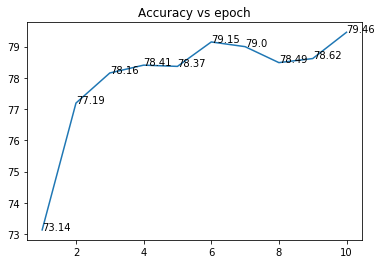

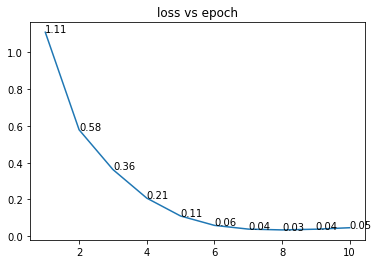

In [13]:
net = models.resnet18(pretrained=True)
net.fc = nn.Linear(512, n_classes)
# net
fit_network(net,10,trainloader,testloader)